# Training SimpleFNO with PML-based frequency-transfer dataset

This notebook trains a SimpleFNO model to map
\\(u_{\omega_\text{src}} \mapsto u_{\omega_\text{tgt}}\\) on a 2D Helmholtz
problem with PML, using precomputed datasets cached on disk.


In [9]:
from pathlib import Path
import sys
import matplotlib.pyplot as plt

# Find project root (dir containing src/)
here = Path().resolve()
PROJECT_ROOT = None
for parent in [here, *here.parents]:
    if (parent / "src" / "__init__.py").exists():
        PROJECT_ROOT = parent
        break

if PROJECT_ROOT is None:
    raise RuntimeError("Could not find project root with src/__init__.py")

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print("PROJECT_ROOT =", PROJECT_ROOT)

from src.config import GridSpec, PMLConfig
from src.ml import SimpleFNO, train_model, eval_relative_metrics, get_freq_dataset


PROJECT_ROOT = C:\Users\31624\Documents\MIT\Programming\FreqTransfer


ImportError: cannot import name 'get_freq_dataset' from 'src.ml' (C:\Users\31624\Documents\MIT\Programming\FreqTransfer\src\ml.py)

## 1. Numerical configuration (grid, PML, frequencies)

We define:

- a 2D grid `GridSpec`,
- a PML configuration `PMLConfig` that matches our "good" choice from the PML tuning notebook,
- source and target frequencies: ω_src → ω_tgt,
- a mapping `omega_to_k(ω)` to convert frequency to wavenumber.


In [5]:
import numpy as np

# --- Grid configuration ---
# Adjust shape / lengths to match your PML tuning notebook
grid = GridSpec(
    dims=2,
    shape=(48, 48),
    lengths=(1.0, 1.0),
)
print("Grid:", grid, "| spacing =", grid.spacing)

# --- PML configuration ---
# Fill in the parameters you found to work well in your PML notebook.
# Example: shell of 16 cells, polynomial order 2, sigma_max 10.0
pml_cfg = PMLConfig(
    thickness=16,
    m=2,
    sigma_max=10.0,
)
print("PML config:", pml_cfg)

# --- Frequency configuration ---
# Map u(omega_src) -> u(omega_tgt)
omega_src = 20.0  # "low" frequency
omega_tgt = 40.0  # "high" frequency

# Relation between frequency and wavenumber k.
# If your physics uses k = omega / c with wave speed c, set that here.
def omega_to_k(omega: float) -> float:
    c = 1.0  # wave speed; adjust if needed
    return float(omega / c)

print(f"omega_src = {omega_src}, omega_tgt = {omega_tgt}")
print(f"k_src = {omega_to_k(omega_src)}, k_tgt = {omega_to_k(omega_tgt)}")


Grid: GridSpec(dims=2, shape=(48, 48), lengths=(1.0, 1.0)) | spacing = (0.02127659574468085, 0.02127659574468085)
PML config: PMLConfig(thickness=16, m=2, sigma_max=10.0)
omega_src = 20.0, omega_tgt = 40.0
k_src = 20.0, k_tgt = 40.0


## 2. Dataset: `HelmholtzFreqTransferDataset` with PML

We now build a dataset of pairs

$u_{\omega_{\text{src}}},\; u_{\omega_{\text{tgt}}}$

for multiple random point-source realizations.

`HelmholtzFreqTransferDataset`:

- uses `RandomPointSource` for each seed,
- calls `solve_with_pml_shell` internally to solve the PDE on an extended grid with PML,
- returns tensors shaped `(2, Ny, Nx)` with `[Re, Im]` channels. 


In [ ]:
# Number of samples we want
n_samples = 200

# Fix seeds for reproducibility
rng = np.random.default_rng(0)
seeds = list(rng.integers(0, 1_000_000, size=n_samples))

# dataset = HelmholtzFreqTransferDataset(
#     grid=grid,
#     pml=pml_cfg,
#     omega_src=omega_src,
#     omega_tgt=omega_tgt,
#     seeds=seeds,
#     omega_to_k=omega_to_k,
# )

# ---- Compute global dataset mean/std for inputs ----

def compute_stats(ds, max_samples=200):
    acc = []
    for i in range(min(len(ds), max_samples)):
        u_src, u_tgt = ds[i]  # BEFORE normalisation
        acc.append(u_src.reshape(2, -1))
    acc = torch.cat(acc, dim=1)
    mean = acc.mean(dim=1)
    std = acc.std(dim=1) + 1e-8
    return mean, std

mean, std = compute_stats(dataset)
print("Computed mean:", mean)
print("Computed std:", std)




print("Number of samples in dataset:", len(dataset))

# Inspect shapes of one sample
u_src, u_tgt = dataset[0]
print("u_src shape:", u_src.shape, "u_tgt shape:", u_tgt.shape)


NameError: name 'np' is not defined

In [6]:
# ======================================================================
# DATASET CONSTRUCTION CELL
# ======================================================================
# Fill in the parameters below to construct any dataset you want.
# This cell builds a clean HelmholtzFreqTransferDataset object.
# ======================================================================

from src.ml import HelmholtzFreqTransferDataset
import numpy as np

# -----------------------------------------------------------
# 1. Choose grid + PML (must match your global definitions)
# -----------------------------------------------------------
grid_cfg   = grid          # e.g. your GridSpec(48,48)
pml_cfg    = pml_cfg       # the PMLConfig you selected earlier

# -----------------------------------------------------------
# 2. Choose source and target frequencies
# -----------------------------------------------------------
omega_src  = 20.0          # frequency of input solution
omega_tgt  = 40.0          # frequency of target solution

# If you want to quickly change:
# omega_src = float(input("Enter ω_src: "))
# omega_tgt = float(input("Enter ω_tgt: "))

# -----------------------------------------------------------
# 3. Choose total dataset size
# -----------------------------------------------------------
N_samples  = 200           # how many samples do you want?

# -----------------------------------------------------------
# 4. Seed generation for reproducibility
# -----------------------------------------------------------
rng   = np.random.default_rng(12345)
seeds = list(rng.integers(0, 1_000_000, size=N_samples))

# -----------------------------------------------------------
# 5. Define ω → k mapping (modify if needed)
# -----------------------------------------------------------
def omega_to_k(omega: float) -> float:
    c = 1.0            # wave speed
    return float(omega / c)

# -----------------------------------------------------------
# 6. Build the dataset
# -----------------------------------------------------------
dataset = HelmholtzFreqTransferDataset(
    grid      = grid_cfg,
    pml       = pml_cfg,
    omega_src = omega_src,
    omega_tgt = omega_tgt,
    seeds     = seeds,
    omega_to_k = omega_to_k,
)

print("=======================================================")
print(" Successfully created frequency-transfer dataset:")
print(f"   - Samples       : {len(dataset)}")
print(f"   - ω_src         : {omega_src}")
print(f"   - ω_tgt         : {omega_tgt}")
print(f"   - Grid size     : {grid_cfg.shape}")
print(f"   - PML config    : {pml_cfg}")
print("=======================================================")

# Test first sample
u_src_test, u_tgt_test = dataset[0]
print("Test load OK:")
print("  u_src shape =", u_src_test.shape)
print("  u_tgt shape =", u_tgt_test.shape)


 Successfully created frequency-transfer dataset:
   - Samples       : 200
   - ω_src         : 20.0
   - ω_tgt         : 40.0
   - Grid size     : (48, 48)
   - PML config    : PMLConfig(thickness=16, m=2, sigma_max=10.0)
Test load OK:
  u_src shape = torch.Size([2, 48, 48])
  u_tgt shape = torch.Size([2, 48, 48])


In [8]:
# ======================================================================
# Cached frequency-transfer dataset builder
# ======================================================================
# Usage example (after this cell):
#
# dataset = get_freq_dataset(
#     grid=grid,
#     pml=pml_cfg,
#     omega_src=20.0,
#     omega_tgt=40.0,
#     N_samples=200,
# )
#
# This will:
#  - construct a unique name from the parameters,
#  - if cached data exists: load X,Y,meta from disk (no solves),
#  - otherwise: solve all samples, save X,Y,meta, then load.
# ======================================================================

from pathlib import Path
import json
import numpy as np
import torch
from torch.utils.data import Dataset

from src.config import DATA_DIR
from src.ml import HelmholtzFreqTransferDataset, np_complex_to_2ch  # HelmholtzFreqTransferDataset uses solve_with_pml_shell


# ---------- Simple dataset wrapper for precomputed arrays ----------

class PrecomputedFreqDataset(Dataset):
    """
    Dataset that serves precomputed (u_src, u_tgt) from X.npy/Y.npy on disk.

    Each item:
      x: (2, H, W) float32  -> source field channels [Re, Im]
      y: (2, H, W) float32  -> target field channels [Re, Im]
    """
    def __init__(self, root: Path):
        self.root = Path(root)
        self.X = np.load(self.root / "X.npy")  # (N,2,H,W)
        self.Y = np.load(self.root / "Y.npy")  # (N,2,H,W)
        with open(self.root / "meta.json", "r") as f:
            self.meta = json.load(f)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        x = torch.from_numpy(self.X[idx]).float()
        y = torch.from_numpy(self.Y[idx]).float()
        return x, y


# ---------- Helper: deterministic name from parameters ----------

def _freq_dataset_name(grid, pml, omega_src, omega_tgt, N_samples):
    H, W = grid.shape
    name = (
        f"wsrc{omega_src:.3f}_wtgt{omega_tgt:.3f}"
        f"_N{N_samples}_"
        f"grid{H}x{W}_"
        f"pmlT{pml.thickness}_m{pml.m}_sig{pml.sigma_max:.2f}"
    )
    # safe for filesystem
    name = name.replace(".", "p")
    return name


# ---------- Public function: build OR load dataset ----------

def get_freq_dataset(
    grid,
    pml,
    omega_src: float,
    omega_tgt: float,
    N_samples: int,
    omega_to_k=None,
    cache_root: Path | None = None,
    overwrite: bool = False,
):
    """
    Build or load a frequency-transfer dataset.

    Parameters
    ----------
    grid : GridSpec
    pml  : PMLConfig
    omega_src, omega_tgt : float
        Source and target frequencies for u(omega_src) -> u(omega_tgt).
    N_samples : int
        Number of samples (random point sources).
    omega_to_k : callable(omega) -> k, optional
        Mapping from frequency to wavenumber. Default: k = omega (c=1).
    cache_root : Path, optional
        Where to store cached datasets. Default: DATA_DIR / "freq_transfer_cached".
    overwrite : bool
        If True, recompute and overwrite existing cache.

    Returns
    -------
    dataset : PrecomputedFreqDataset
        Ready-to-use dataset with precomputed fields and metadata.
    """
    if omega_to_k is None:
        def omega_to_k(omega: float) -> float:
            c = 1.0
            return float(omega / c)

    if cache_root is None:
        cache_root = DATA_DIR / "freq_transfer_cached"

    cache_root = Path(cache_root)
    cache_root.mkdir(parents=True, exist_ok=True)

    name = _freq_dataset_name(grid, pml, omega_src, omega_tgt, N_samples)
    ds_dir = cache_root / name

    # ---------------------------------------------------------
    # Case 1: cache exists and we keep it -> just load
    # ---------------------------------------------------------
    if ds_dir.exists() and not overwrite:
        print(f"[get_freq_dataset] Loading cached dataset from: {ds_dir}")
        ds = PrecomputedFreqDataset(ds_dir)
        print(f"  Loaded N={len(ds)} samples, meta: ω_src={ds.meta['omega_src']}, ω_tgt={ds.meta['omega_tgt']}")
        return ds

    # ---------------------------------------------------------
    # Case 2: no cache yet OR overwrite requested -> compute
    # ---------------------------------------------------------
    print(f"[get_freq_dataset] Generating new dataset: {name}")
    ds_dir.mkdir(parents=True, exist_ok=True)

    # Make reproducible seeds
    rng = np.random.default_rng(12345)
    seeds = list(rng.integers(0, 1_000_000, size=N_samples))

    # Online dataset that actually solves the PDE
    online_ds = HelmholtzFreqTransferDataset(
        grid=grid,
        pml=pml,
        omega_src=omega_src,
        omega_tgt=omega_tgt,
        seeds=seeds,
        omega_to_k=omega_to_k,
    )

    # Peek at shape
    u_src0, u_tgt0 = online_ds[0]
    C, H, W = u_src0.shape
    X = np.zeros((N_samples, C, H, W), dtype=np.float32)
    Y = np.zeros((N_samples, C, H, W), dtype=np.float32)

    # Loop over all samples once and store
    for i in range(N_samples):
        if i % max(1, N_samples // 10) == 0:
            print(f"  solving sample {i}/{N_samples} ...")
        u_src, u_tgt = online_ds[i]   # torch tensors (2,H,W)
        X[i] = u_src.numpy()
        Y[i] = u_tgt.numpy()

    # Save arrays
    np.save(ds_dir / "X.npy", X)
    np.save(ds_dir / "Y.npy", Y)

    # Save metadata
    meta = {
        "omega_src": float(omega_src),
        "omega_tgt": float(omega_tgt),
        "grid_shape": list(grid.shape),
        "grid_lengths": list(grid.lengths),
        "pml": {
            "thickness": int(pml.thickness),
            "m": int(pml.m),
            "sigma_max": float(pml.sigma_max),
        },
        "N_samples": int(N_samples),
        "seeds": seeds,
    }
    with open(ds_dir / "meta.json", "w") as f:
        json.dump(meta, f, indent=2)

    print(f"[get_freq_dataset] Saved dataset to {ds_dir}")
    print(f"  X.npy shape: {X.shape}")
    print(f"  Y.npy shape: {Y.shape}")

    # Finally, load as PrecomputedFreqDataset (so later runs don't solve)
    ds = PrecomputedFreqDataset(ds_dir)
    return ds


In [ ]:
dataset1 = HelmholtzFreqTransferDataset(
    grid=grid,
    pml=pml_cfg,
    omega_src=omega_src,
    omega_tgt=omega_tgt,
    seeds=seeds,
    omega_to_k=omega_to_k,
    mean=mean,
    std=std,
    normalise=True,      # <<< enable normalisation
)


## 3. Quick sanity check (optional visualization)

We can quickly inspect the magnitude of a source and target field to see that the
solutions look reasonable and that the mapping is non-trivial.


In [7]:
import matplotlib.pyplot as plt

def plot_complex_field(u, title: str):
    """u: (2, Ny, Nx) tensor with [Re, Im]."""
    u_np = u.numpy()
    u_complex = u_np[0] + 1j * u_np[1]
    mag = np.abs(u_complex)
    fig, ax = plt.subplots()
    im = ax.imshow(mag, origin="lower")
    fig.colorbar(im, ax=ax)
    ax.set_title(title)
    plt.show()

plot_complex_field(u_src, "Magnitude |u_src (omega_src)|")
plot_complex_field(u_tgt, "Magnitude |u_tgt (omega_tgt)|")


NameError: name 'u_src' is not defined

## 4. Model: SimpleFNO for frequency transfer

We use `SimpleFNO`:

- Input shape: `(B, C_in, Ny, Nx)`
- Output shape: `(B, 2, Ny, Nx)` (Re/Im of target field)

Here `C_in = 2` because we only feed the source field `[Re, Im]`.
We can later extend this to include extra channels (e.g., k-map or medium).


In [6]:
import torch

# Infer channels from one sample
sample_x, sample_y = dataset[0]
in_channels = sample_x.shape[0]   # should be 2
out_channels = sample_y.shape[0]  # should be 2

print("in_channels =", in_channels, "out_channels =", out_channels)

# Construct a small FNO-style model
model = SimpleFNO(
    in_ch=in_channels,
    width=48,              # model width (can tune)
    modes=(12, 12),        # spectral modes in each dimension
    layers=4,              # number of FNO layers
)
model


in_channels = 2 out_channels = 2


SimpleFNO(
  (proj_in): Conv2d(2, 48, kernel_size=(1, 1), stride=(1, 1))
  (spectral): ModuleList(
    (0-3): 4 x SpectralConv2d()
  )
  (w): ModuleList(
    (0-3): 4 x Conv2d(48, 48, kernel_size=(1, 1), stride=(1, 1))
  )
  (act): GELU(approximate='none')
  (proj_out): Conv2d(48, 2, kernel_size=(1, 1), stride=(1, 1))
)

## 5. Training loop with `train_model`

We use the generic helper:

```python
train_model(model, dataset, epochs, batch_size, lr, val_split)


In [7]:
### 🎯 Cell 12 — Code: train the model

# Training hyperparameters
epochs = 50
batch_size = 8
learning_rate = 1e-3

model, history = train_model(
    model=model,
    dataset=dataset,
    epochs=epochs,
    batch_size=batch_size,
    lr=learning_rate,
    val_split=0.2,
    device=None,   # auto: "cuda" if available, else "cpu"
    verbose=True,
)


[001/50] train=1.0905e+02  val=5.2851e+00
[002/50] train=2.4153e+00  val=3.1512e-01
[003/50] train=1.1827e-01  val=3.5854e-02
[004/50] train=2.5341e-02  val=1.7412e-02
[005/50] train=1.3633e-02  val=1.0884e-02
[006/50] train=9.4445e-03  val=8.0587e-03
[007/50] train=7.1471e-03  val=6.2591e-03
[008/50] train=5.6142e-03  val=4.9700e-03
[009/50] train=4.4840e-03  val=3.9906e-03
[010/50] train=3.6111e-03  val=3.2233e-03
[011/50] train=2.9228e-03  val=2.6151e-03
[012/50] train=2.3762e-03  val=2.1316e-03
[013/50] train=1.9418e-03  val=1.7476e-03
[014/50] train=1.5973e-03  val=1.4436e-03
[015/50] train=1.3248e-03  val=1.2035e-03
[016/50] train=1.1099e-03  val=1.0143e-03
[017/50] train=9.4057e-04  val=8.6532e-04
[018/50] train=8.0723e-04  val=7.4788e-04
[019/50] train=7.0196e-04  val=6.5495e-04
[020/50] train=6.1842e-04  val=5.8094e-04
[021/50] train=5.5163e-04  val=5.2146e-04
[022/50] train=4.9768e-04  val=4.7309e-04
[023/50] train=4.5354e-04  val=4.3324e-04
[024/50] train=4.1694e-04  val=3.9

## 6. Inspect training history

We can visualize the train/val MSE curves to check for under/overfitting.


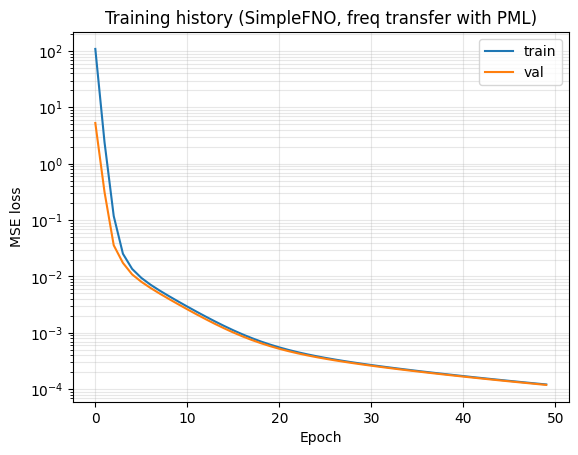

In [8]:
train_loss = history["train"]
val_loss = history["val"]

plt.figure()
plt.plot(train_loss, label="train")
plt.plot(val_loss, label="val")
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.title("Training history (SimpleFNO, freq transfer with PML)")
plt.legend()
plt.grid(True, which="both", alpha=0.3)
plt.show()


## 7. Quantitative evaluation: `eval_relative_metrics`

We compute:

- mean / median / 90th percentile relative L2 error per sample,
- magnitude RMSE,
- phase RMSE (phase difference wrapped to \\([-π, π]\\)).


In [9]:
metrics = eval_relative_metrics(
    model=model,
    dataset=dataset,
    batch_size=16,
)

metrics


{'rel_L2_mean': 639.271732788086,
 'rel_L2_median': 578.9997863769531,
 'rel_L2_p90': 959.2643127441406,
 'mag_RMSE': 0.015422764650675515,
 'phase_RMSE': 1.8128010679374713}

## 8. Save trained model

We store the model weights in the standard `RESULTS_DIR` for later reuse.


In [10]:
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

model_path = RESULTS_DIR / "simplefno_freq_transfer_pml.pt"
torch.save(model.state_dict(), model_path)

print("Saved model weights to:", model_path)


Saved model weights to: C:\Users\31624\Documents\MIT\Programming\FreqTransfer\data\results\simplefno_freq_transfer_pml.pt


### 3.1 Basic sanity: shapes, determinism, seeds

We check:

- that samples have consistent shapes,
- that `__getitem__` is deterministic (same index → same field),
- that seeds are unique (no accidental duplication of RHS),
- that the source and target norms are nonzero and on a reasonable scale.


In [11]:
import torch

print("Dataset size:", len(dataset))

# Shape + nonzero check for a few samples
for idx in [0, 1, 2]:
    u_src, u_tgt = dataset[idx]
    print(f"\nSample {idx}:")
    print("  u_src shape:", tuple(u_src.shape))
    print("  u_tgt shape:", tuple(u_tgt.shape))
    print("  ||u_src||_2 =", torch.linalg.vector_norm(u_src).item())
    print("  ||u_tgt||_2 =", torch.linalg.vector_norm(u_tgt).item())

# Determinism check: same index → same tensor
idx = 0
u_src_1, u_tgt_1 = dataset[idx]
u_src_2, u_tgt_2 = dataset[idx]

print("\nDeterminism:")
print("  max |u_src_1 - u_src_2| =", (u_src_1 - u_src_2).abs().max().item())
print("  max |u_tgt_1 - u_tgt_2| =", (u_tgt_1 - u_tgt_2).abs().max().item())

# Seed uniqueness
import numpy as np
seeds = np.array(dataset.seeds)
print("\nSeed diagnostics:")
print("  # seeds        :", len(seeds))
print("  # unique seeds :", len(np.unique(seeds)))


Dataset size: 200

Sample 0:
  u_src shape: (2, 48, 48)
  u_tgt shape: (2, 48, 48)
  ||u_src||_2 = 0.001221860758960247
  ||u_tgt||_2 = 0.0009296949137933552

Sample 1:
  u_src shape: (2, 48, 48)
  u_tgt shape: (2, 48, 48)
  ||u_src||_2 = 0.0023724224884063005
  ||u_tgt||_2 = 0.0017824635142460465

Sample 2:
  u_src shape: (2, 48, 48)
  u_tgt shape: (2, 48, 48)
  ||u_src||_2 = 0.0016018503811210394
  ||u_tgt||_2 = 0.0012326515279710293

Determinism:
  max |u_src_1 - u_src_2| = 0.0
  max |u_tgt_1 - u_tgt_2| = 0.0

Seed diagnostics:
  # seeds        : 200
  # unique seeds : 200


### 3.2 Global statistics of field norms

We look at the distribution of:

- ‖u_src‖₂ and ‖u_tgt‖₂ across the dataset.

This tells us whether:
- scaling is roughly consistent,
- there are extreme outliers,
- the target is systematically “stronger” or “weaker” than the source.


u_src norms: mean = 0.00169786738086259  std = 0.0005124368630098526
u_tgt norms: mean = 0.001285161653358955  std = 0.0003898271528259175


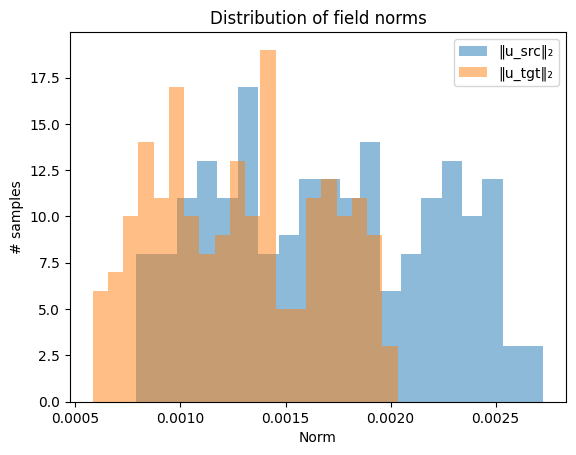

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def compute_norms(ds, max_samples=200):
    n = min(len(ds), max_samples)
    norms_src = np.zeros(n)
    norms_tgt = np.zeros(n)
    for i in range(n):
        u_src, u_tgt = ds[i]
        norms_src[i] = torch.linalg.vector_norm(u_src).item()
        norms_tgt[i] = torch.linalg.vector_norm(u_tgt).item()
    return norms_src, norms_tgt

norms_src, norms_tgt = compute_norms(dataset, max_samples=200)

print("u_src norms: mean =", norms_src.mean(), " std =", norms_src.std())
print("u_tgt norms: mean =", norms_tgt.mean(), " std =", norms_tgt.std())

plt.figure()
plt.hist(norms_src, bins=20, alpha=0.5, label="‖u_src‖₂")
plt.hist(norms_tgt, bins=20, alpha=0.5, label="‖u_tgt‖₂")
plt.xlabel("Norm")
plt.ylabel("# samples")
plt.legend()
plt.title("Distribution of field norms")
plt.show()


### 3.3 PDE residual: does each sample satisfy the discrete Helmholtz system?

For a few random samples and both frequencies (ω_src, ω_tgt), we:

1. Reconstruct the RHS `b_phys` on the physical grid.
2. Embed it into the extended grid with PML as in `solve_with_pml_shell`.
3. Assemble the extended operator A_ext with PML.
4. Compute the relative residual:

\\[
\frac{\|A_{\text{ext}} u_{\text{ext}} - b_{\text{ext}}\|_2}{\|b_{\text{ext}}\|_2}.
\\]

This should be very small (close to machine precision) for a direct LU solve.


In [13]:
from src.loads import RandomPointSource, build_load
from src.operators import make_extended_grid, assemble_operator, solve_with_pml_shell

def helmholtz_residual_for_sample(ds, idx: int, omega: float):
    grid_phys = ds.grid
    pml = ds.pml
    seed = ds.seeds[idx]
    k = float(ds.omega_to_k(omega))

    # RHS on physical grid
    rhs_spec = RandomPointSource(seed=seed)
    b_phys = build_load(rhs_spec, grid_phys)  # (N_phys,)

    # Extended grid + embedded RHS (same as solve_with_pml_shell)
    T = pml.thickness
    ny, nx = grid_phys.shape
    grid_ext = make_extended_grid(grid_phys, pml)
    ny_ext, nx_ext = grid_ext.shape

    b_ext_2d = np.zeros(grid_ext.shape, dtype=b_phys.dtype)
    b_ext_2d[T:T+ny, T:T+nx] = b_phys.reshape(grid_phys.shape)
    b_ext = b_ext_2d.ravel()

    # Solve once to get u_ext (we could also re-use solve_with_pml_shell)
    u_phys, u_ext_2d, grid_ext2 = solve_with_pml_shell(grid_phys, k, b_phys, pml)
    assert grid_ext2.shape == grid_ext.shape
    u_ext = u_ext_2d.ravel()

    # Assemble A_ext and compute residual
    A_ext = assemble_operator(grid_ext, k=k, kind="helmholtz", pml=pml)
    r_ext = A_ext.dot(u_ext) - b_ext
    rel_res = np.linalg.norm(r_ext) / np.linalg.norm(b_ext)

    return rel_res

# Check a few samples at both frequencies
indices = [0, 1, 5]
for idx in indices:
    r_src = helmholtz_residual_for_sample(dataset, idx, omega_src)
    r_tgt = helmholtz_residual_for_sample(dataset, idx, omega_tgt)
    print(f"Sample {idx}: residual src={r_src:.3e}, tgt={r_tgt:.3e}")


Sample 0: residual src=4.229e-15, tgt=3.880e-15
Sample 1: residual src=4.725e-15, tgt=4.157e-15
Sample 5: residual src=3.951e-15, tgt=4.277e-15


### 3.4 PML quality: energy in PML region vs interior

We quantify how well the PML damps waves by comparing:

- the max magnitude inside the physical domain,
- the max magnitude inside the PML shell,

for both ω_src and ω_tgt and a few samples.
We expect the PML magnitude to be much smaller than the interior magnitude.


In [14]:
def pml_energy_ratio_for_sample(ds, idx: int, omega: float):
    grid_phys = ds.grid
    pml = ds.pml
    seed = ds.seeds[idx]
    k = float(ds.omega_to_k(omega))

    rhs_spec = RandomPointSource(seed=seed)
    b_phys = build_load(rhs_spec, grid_phys)

    u_phys_flat, u_ext_2d, grid_ext = solve_with_pml_shell(grid_phys, k, b_phys, pml)

    T = pml.thickness
    ny, nx = grid_phys.shape

    # Interior magnitude
    u_int = u_ext_2d[T:T+ny, T:T+nx]
    mag_int = np.abs(u_int)
    max_int = mag_int.max()

    # PML region = everything outside that interior block
    mask_pml = np.ones_like(u_ext_2d, dtype=bool)
    mask_pml[T:T+ny, T:T+nx] = False
    mag_pml = np.abs(u_ext_2d)[mask_pml]
    max_pml = mag_pml.max() if mag_pml.size > 0 else 0.0

    ratio = max_pml / max_int if max_int > 0 else np.nan
    return max_int, max_pml, ratio

for idx in [0, 1, 5]:
    for omega in [omega_src, omega_tgt]:
        max_int, max_pml, ratio = pml_energy_ratio_for_sample(dataset, idx, omega)
        print(
            f"Sample {idx}, omega={omega}: "
            f"max_int={max_int:.3e}, max_pml={max_pml:.3e}, ratio={ratio:.3e}"
        )


Sample 0, omega=20.0: max_int=1.522e-04, max_pml=2.480e-05, ratio=1.629e-01
Sample 0, omega=40.0: max_int=1.311e-04, max_pml=1.895e-05, ratio=1.446e-01
Sample 1, omega=20.0: max_int=2.940e-04, max_pml=4.747e-05, ratio=1.615e-01
Sample 1, omega=40.0: max_int=2.505e-04, max_pml=3.555e-05, ratio=1.419e-01
Sample 5, omega=20.0: max_int=2.641e-04, max_pml=1.528e-04, ratio=5.788e-01
Sample 5, omega=40.0: max_int=2.255e-04, max_pml=1.220e-04, ratio=5.412e-01


### 3.5 Baseline mapping: scaled `u_src` as a trivial predictor

As a trivial baseline we:

1. Scale `u_src` so that ‖u_src_scaled‖₂ = ‖u_tgt‖₂,
2. Compute the relative L² error between `u_src_scaled` and `u_tgt`.

This gives a "no ML" baseline error. The neural network should aim to do significantly better.


In [15]:
def relative_l2(u, v):
    num = torch.linalg.vector_norm(u - v).item()
    den = torch.linalg.vector_norm(v).item()
    return num / den if den > 0 else np.nan

def baseline_scaled_src_error(ds, max_samples=100):
    n = min(len(ds), max_samples)
    errs = np.zeros(n)
    for i in range(n):
        u_src, u_tgt = ds[i]
        norm_src = torch.linalg.vector_norm(u_src).item()
        norm_tgt = torch.linalg.vector_norm(u_tgt).item()
        if norm_src == 0 or norm_tgt == 0:
            errs[i] = np.nan
            continue
        scale = norm_tgt / norm_src
        u_src_scaled = u_src * scale
        errs[i] = relative_l2(u_src_scaled, u_tgt)
    return errs

errs = baseline_scaled_src_error(dataset, max_samples=100)
print("Baseline scaled-src relative error:")
print("  mean =", np.nanmean(errs))
print("  median =", np.nanmedian(errs))
print("  90th percentile =", np.nanpercentile(errs, 90))


Baseline scaled-src relative error:
  mean = 1.4221734156387993
  median = 1.4236445106805342
  90th percentile = 1.4437999061678033
